# Data Processing

In [36]:
import json
import os
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import os
import numpy as np
import neurokit2 as nk
SF = 26

In [37]:
def convert_to_dataframe(user_data):
    # Extract user details
    details = user_data["user_details"]
    name = details['name']
    # Create DataFrame for timestamp and feature signals
    df = pd.DataFrame({
        "timestamp": user_data["timestamp"],
        "ECG": user_data["ecg"],
        "GSR": user_data["gsr"],
        "PPG_red": user_data["ppg_red"],
        "PPG_ir": user_data["ppg_ir"],
        "PPG_green": user_data["ppg_green"]
    })
    
    df.attrs = details
    
    return name, df

In [38]:
FileNames = ["LAURIE_ECG_ARM_PPG_INDEX_2024-02-19_17-34-31", "LAURIE_FEATURE_TEST_2024-02-19_17-10-04","Laurie_3200_2024-02-22_14-56-44", "laurie long_2024-02-22_15-16-14"]

# Dictionary to hold DataFrames for each file
dataframes = {}

# Base path assumes files are one directory up from the current script's directory
base_path = os.path.join(os.getcwd(), '..')

# Loop through each file in FileNames
for file_name in FileNames:
    json_file_path = os.path.join(base_path, f"{file_name}.json")  # Construct file path
    normalized_path = os.path.normpath(json_file_path)  # Normalize the path

    try:
        with open(normalized_path, 'r') as file:
            data = json.load(file)
        print(f"JSON data successfully loaded from {file_name}.")
        
        # Convert dictionary to pandas DataFrame
        name, df = convert_to_dataframe(data)
        
        # Store the DataFrame in the dictionary
        dataframes[name] = df

    except Exception as e:
        print(f"Failed to load JSON data from {file_name}: {e}")
        
# my_data = dataframes['LAURIE_ECG_ARM_PPG_INDEX']
my_data = dataframes['laurie long']


JSON data successfully loaded from LAURIE_ECG_ARM_PPG_INDEX_2024-02-19_17-34-31.
JSON data successfully loaded from LAURIE_FEATURE_TEST_2024-02-19_17-10-04.
JSON data successfully loaded from Laurie_3200_2024-02-22_14-56-44.
JSON data successfully loaded from laurie long_2024-02-22_15-16-14.


# ECG

Text(0.5, 1.0, 'Cleaned ECG')

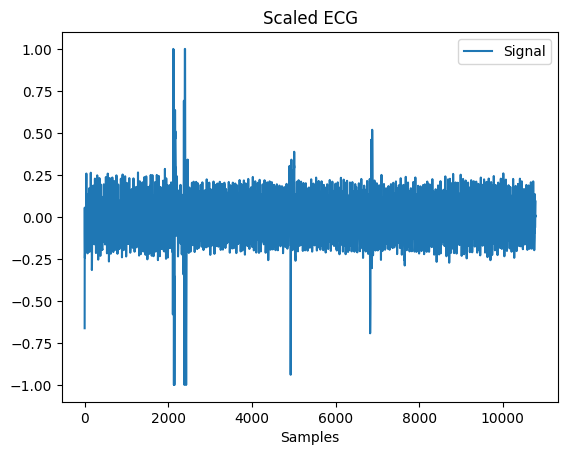

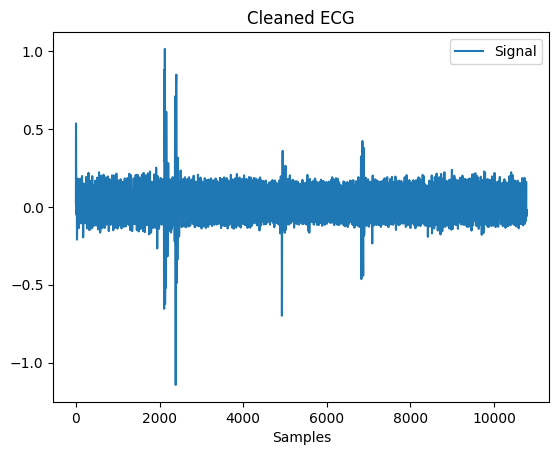

In [47]:
from sklearn.preprocessing import RobustScaler

# Calculate the mean and standard deviation
mean = my_data['ECG'].mean()
std_dev = my_data['ECG'].std()

remove_outlier = False
if remove_outlier:
    # Define your threshold for deviation from the mean
    threshold = 2

    # Filter out outliers
    outliers_mask = (my_data['ECG'] < mean - threshold * std_dev) | (my_data['ECG'] > mean + threshold * std_dev)

    outliers = my_data['ECG'][outliers_mask]

    filtered_ecg = my_data['ECG'][~outliers_mask]

    nk.signal_plot(my_data['ECG'])

    fig = plt.gcf()
    plt.title('Raw ECG')

    plt.figure()
    plt.scatter(my_data['timestamp'][outliers_mask], outliers, color = 'red')
    plt.scatter(my_data['timestamp'][~outliers_mask], filtered_ecg, color = 'blue')
    plt.title('Outlier Removal')
    # Reshape data for the scaler
    data_reshaped = filtered_ecg.values.reshape(-1, 1)
    
else:
    data_reshaped = my_data['ECG'].values.reshape(-1, 1)
    
# Initialize the RobustScaler
robust_scaler = RobustScaler()

# Fit and transform the data with RobustScaler
data_robust_scaled = robust_scaler.fit_transform(data_reshaped)

# Manually scale to [-1, 1] based on the robustly scaled data
data_scaled_to_range = np.interp(data_robust_scaled, (data_robust_scaled.min(), data_robust_scaled.max()), (-1, 1))

# Convert back to a pandas series, if needed
ecg_data = pd.Series(data_scaled_to_range.flatten())

nk.signal_plot(ecg_data)

fig = plt.gcf()
plt.title('Scaled ECG')

# Process ecg
ecg_signals, info = nk.ecg_process(ecg_data, sampling_rate = SF, method = 'neurokit')
nk.signal_plot(ecg_signals['ECG_Clean'])
fig = plt.gcf()
plt.title('Cleaned ECG') 



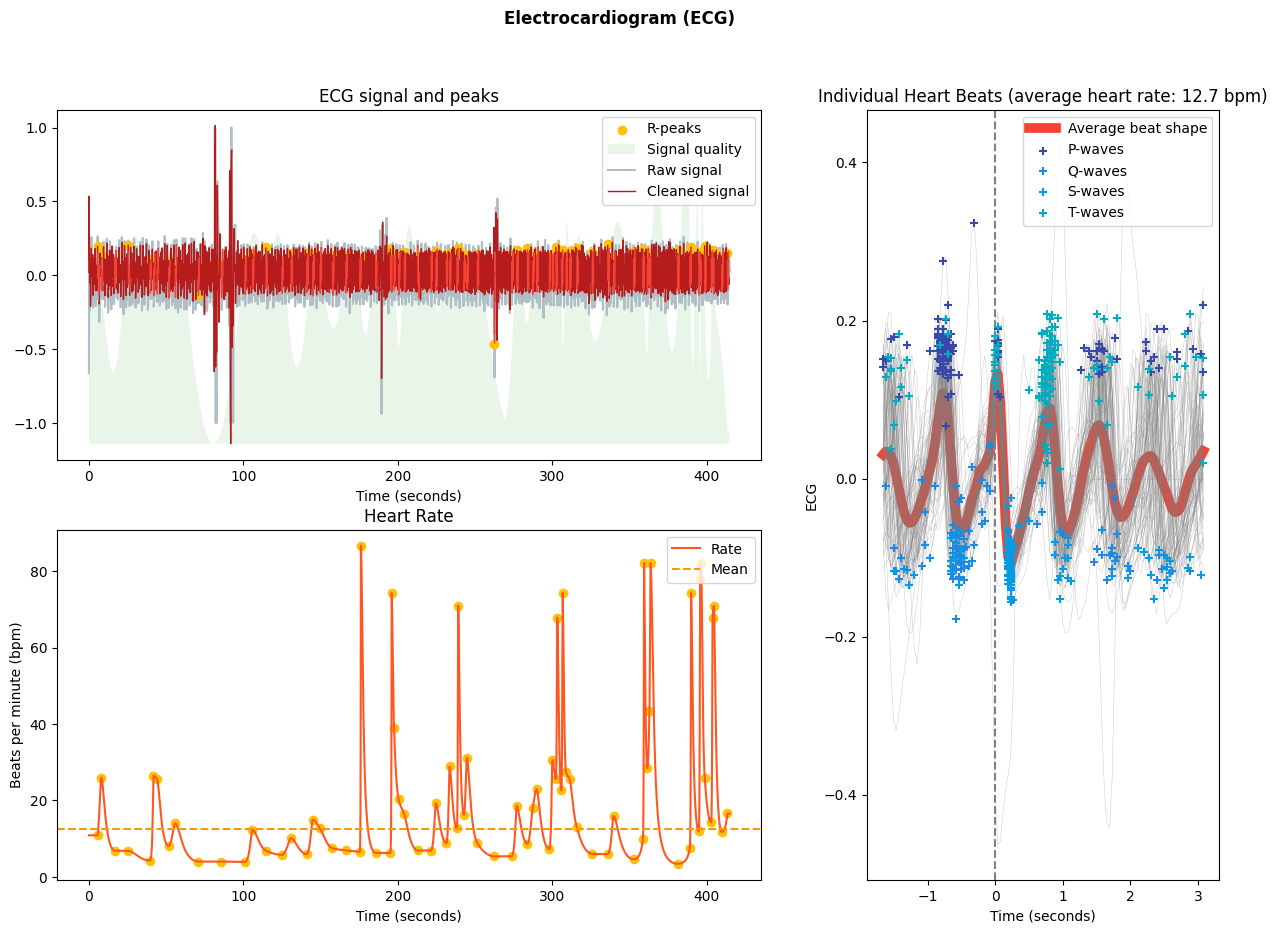

In [48]:
nk.ecg_plot(ecg_signals, info)
fig = plt.gcf()
fig.set_size_inches(15, 10, forward=True)
# fig.savefig("myfig.png")

### Interval ECG

In [41]:
# nk.ecg_intervalrelated(ecg_signals)
# # Half the data
# epochs = nk.epochs_create(ecg_signals, 
#                           events=[0, 2000], 
#                           sampling_rate=SR, 
#                           epochs_start=0, 
#                           epochs_end=150)

# # Analyze
# nk.ecg_intervalrelated(epochs)

### Respiration ECG

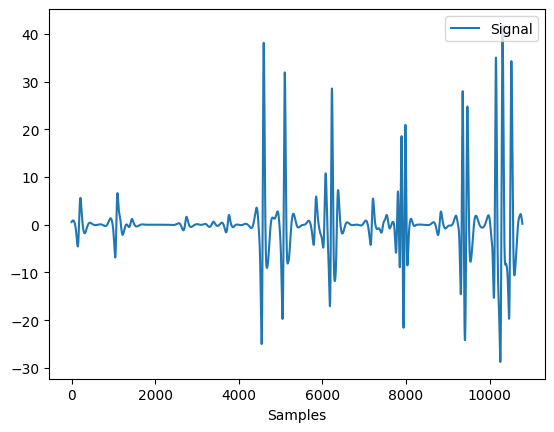

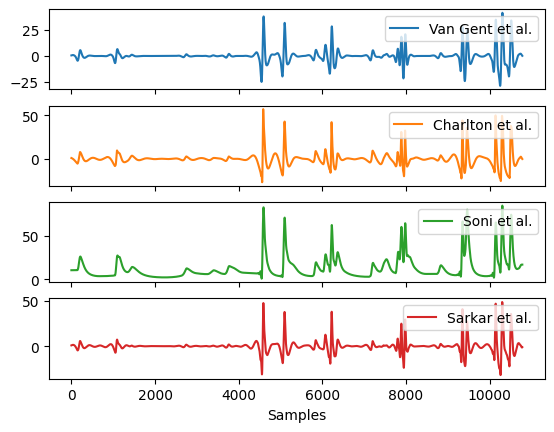

In [49]:
# Extract peaks
rpeaks, info = nk.ecg_peaks(ecg_signals, sampling_rate=SF)

# Compute rate
ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=SF, desired_length=len(my_data["ECG"]))

edr = nk.ecg_rsp(ecg_rate, sampling_rate=SF)

# Visual comparison
nk.signal_plot(edr)

edr_df = pd.DataFrame({
    "Van Gent et al.": nk.ecg_rsp(ecg_rate, sampling_rate=SF),
    "Charlton et al." : nk.ecg_rsp(ecg_rate, sampling_rate=SF, method="charlton2016"),
    "Soni et al.": nk.ecg_rsp(ecg_rate, sampling_rate=SF, method="soni2019"),
    "Sarkar et al.": nk.ecg_rsp(ecg_rate, sampling_rate=SF, method="sarkar2015")
    })

nk.signal_plot(edr_df, subplots=True)

# PPG

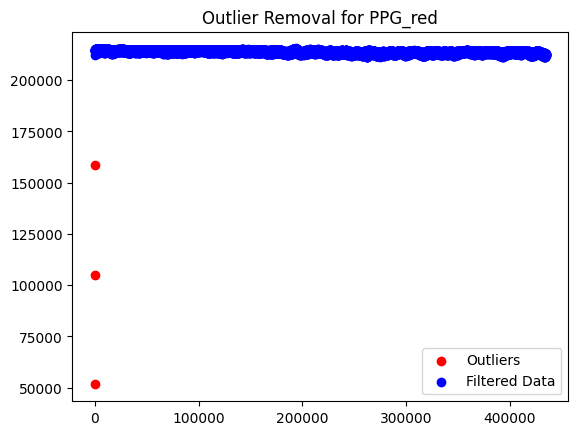

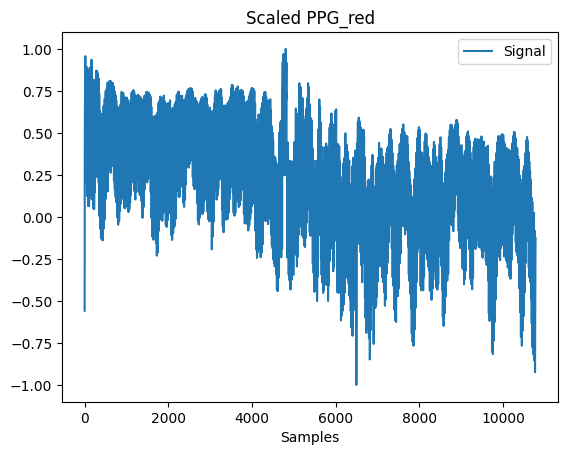

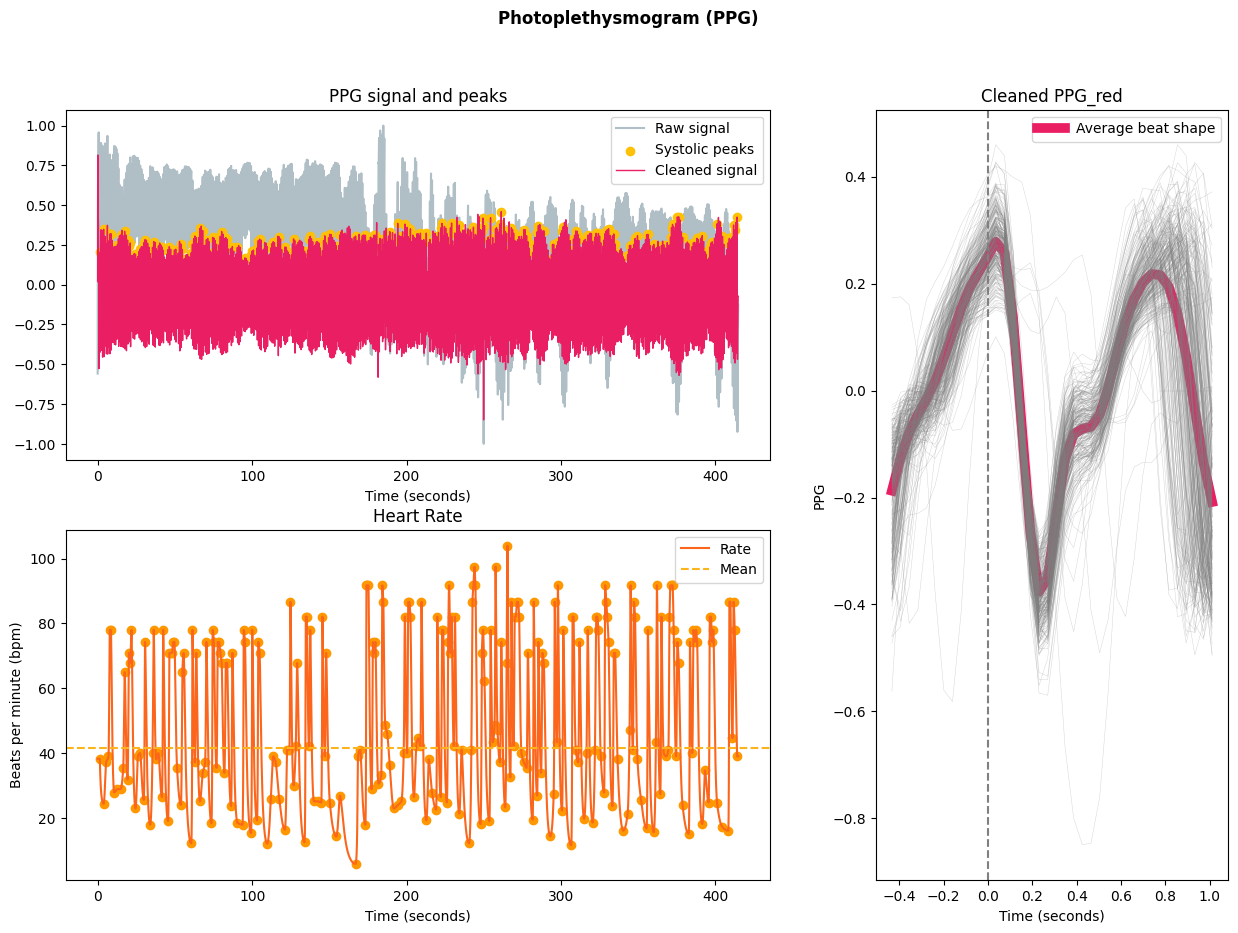

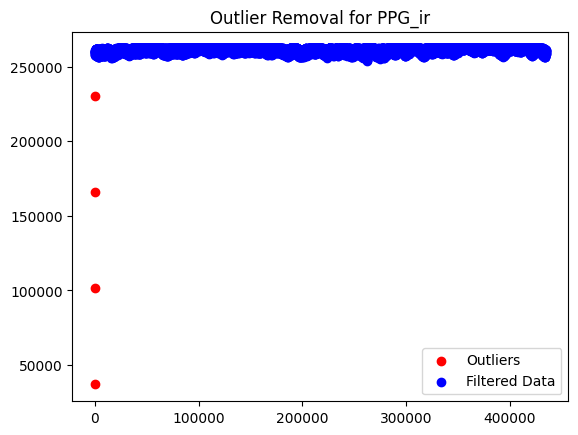

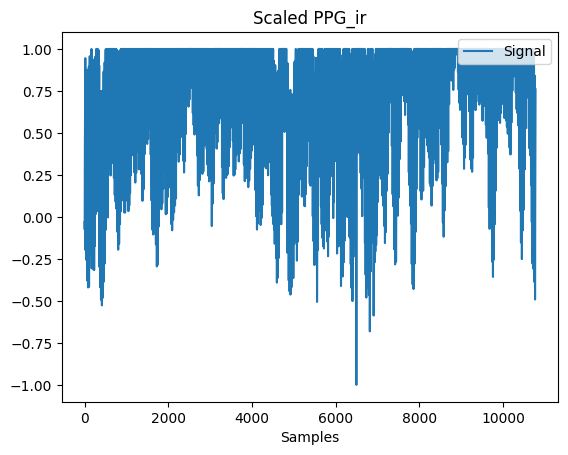

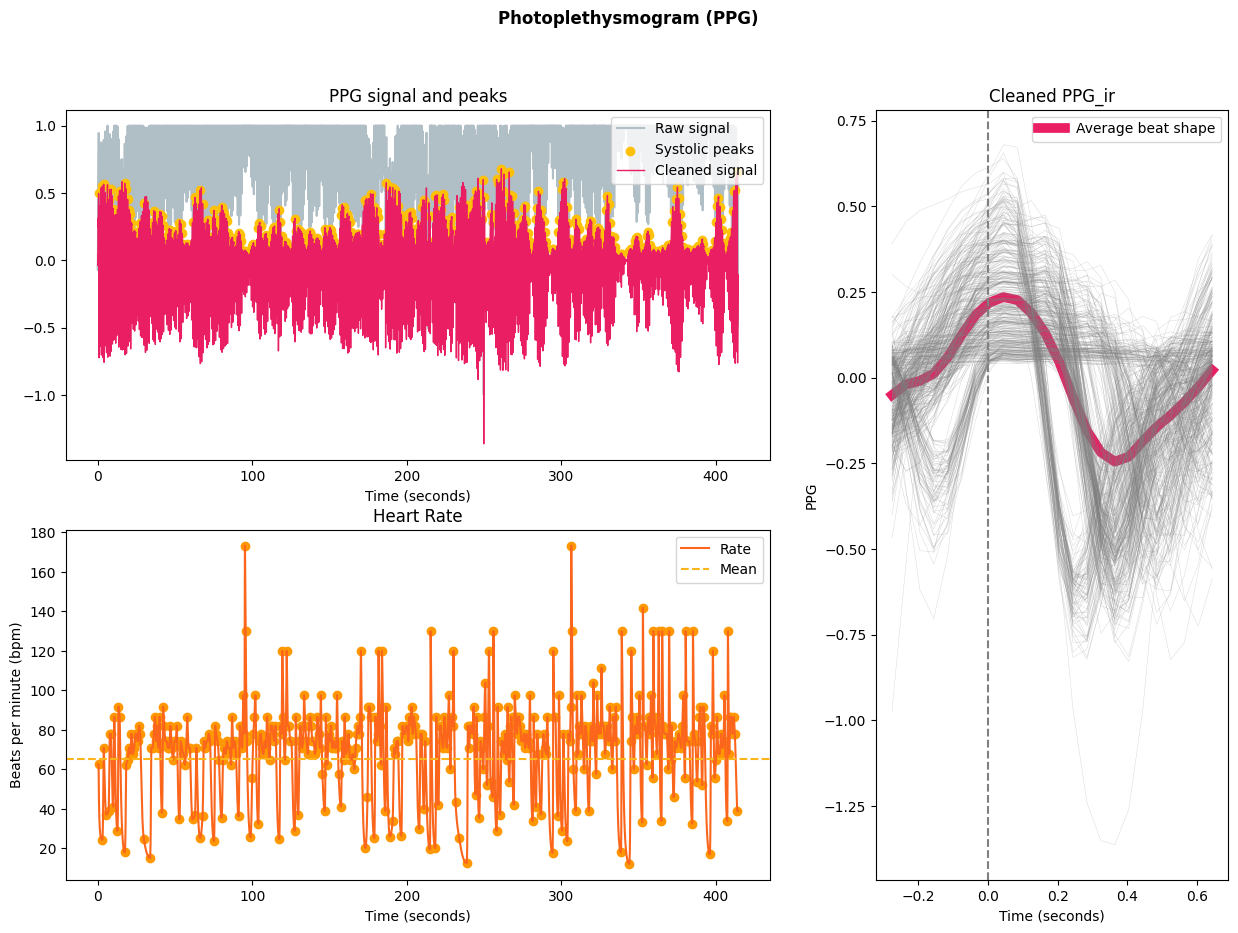

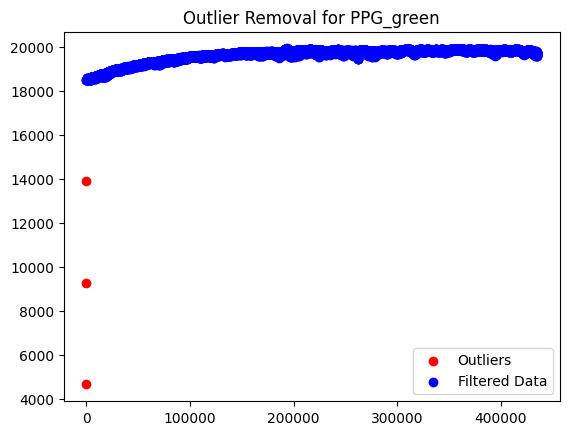

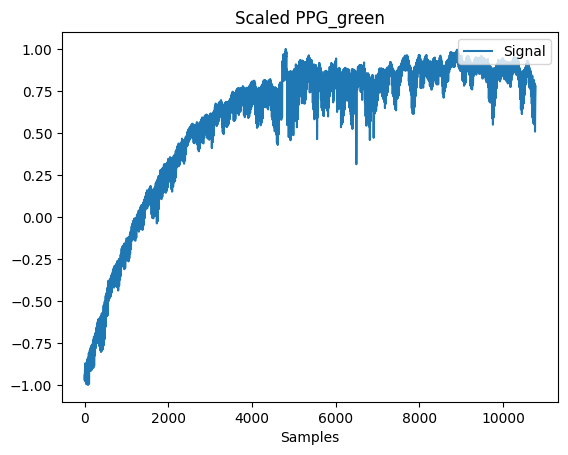

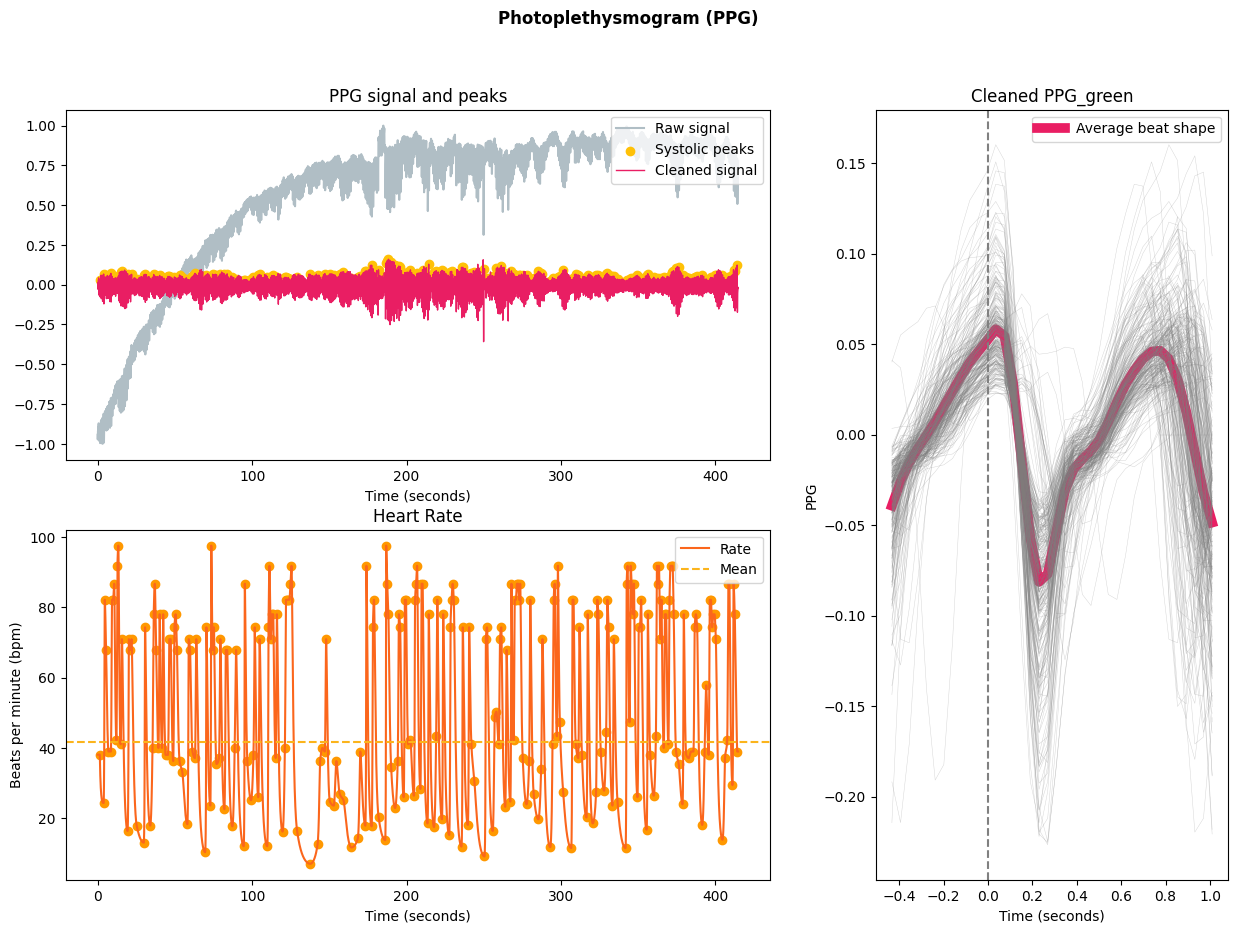

In [53]:
my_data = dataframes['LAURIE_FEATURE_TEST']

from sklearn.preprocessing import RobustScaler

# Columns to process
columns_to_process = ["PPG_red", "PPG_ir", "PPG_green"]

# Define your threshold for deviation from the mean
threshold = 5

ppg_data = []
info = []

for column in columns_to_process:
    
    data = my_data[column]
    # Calculate the mean and standard deviation for each column
    mean = data.mean()
    std_dev = data.std()

    # Filter out outliers
    outliers_mask = (data < mean - threshold * std_dev) | (data > mean + threshold * std_dev)
    outliers = data[outliers_mask]
    filtered_ppg = data[~outliers_mask]

    # Plotting
    plt.figure()
    plt.scatter(my_data['timestamp'][outliers_mask], outliers, color='red', label='Outliers')
    plt.scatter(my_data['timestamp'][~outliers_mask], filtered_ppg, color='blue', label='Filtered Data')
    plt.title(f'Outlier Removal for {column}')
    plt.legend()

    # Reshape data for the scaler
    data_reshaped = filtered_ppg.values.reshape(-1, 1)

    # Initialize the RobustScaler
    robust_scaler = RobustScaler()

    # Fit and transform the data with RobustScaler
    data_robust_scaled = robust_scaler.fit_transform(data_reshaped)

    # Manually scale to [-1, 1] based on the robustly scaled data
    data_scaled_to_range = np.interp(data_robust_scaled, (data_robust_scaled.min(), data_robust_scaled.max()), (-1, 1))

    # Convert back to a pandas series
    ppg_data_scaled = pd.Series(data_scaled_to_range.flatten(), name=column + "_scaled")

    # Append the scaled data to my_data DataFrame or handle it as needed
    my_data[column + "_scaled"] = ppg_data_scaled

    # Plotting scaled data
    nk.signal_plot(ppg_data_scaled)  # This line assumes you want to plot with neurokit2, adjust as necessary
    fig = plt.gcf()
    plt.title(f'Scaled {column}')
    
    ppg_data[column], info[column] = nk.ppg_process(ppg_data_scaled, sampling_rate=SF, method='elgendi', report=None)
    nk.ppg_plot(ppg_data[column], info[column])
    fig = plt.gcf()
    fig.set_size_inches(15, 10, forward=True)
    plt.title(f'Cleaned {column}')
plt.show()

# All data

In [ ]:
# Process the signal
data_clean, info = nk.bio_process(ecg=data["ECG"], 
                                  rsp=data["RSP"], 
                                  eda=data["EDA"], 
                                  keep=data["Photosensor"], 
                                  sampling_rate=100)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", "EDA_Phasic", "Photosensor"]].plot(subplots=True)

KeyError: 'ECG'

Use the nk.data() function to load the dataset located on NeuroKit data folder.

It contains 2.5 minutes of biosignals recorded at a frequency of 100Hz (2.5 x 60 x 100 = 15000 data points).

Biosignals : ECG, RSP, EDA + Photosensor (event signal)

This is the data from one participant that saw 4 emotional and neutral images from the IAPS), which we will refer to as events.

Importantly, the images were marked in the recording system (the “triggers”) by a small black rectangle on the screen, which led to the photosensor signal to go down (and then up again after the image). This is what will allow us to retrieve the location of these events.

They were 2 types of images (the condition) that were shown to the participant: “Negative” vs. “Neutral” (in terms of emotion). Each picture was presented for 3 seconds. The following list is the condition order.

In [ ]:
# Download data
data = nk.data("bio_eventrelated_100hz")

print(data)

            ECG        EDA  Photosensor       RSP
0     -0.015869  13.196868          5.0  0.778931
1     -0.011703  13.197173          5.0  0.777588
2     -0.009766  13.197020          5.0  0.777435
3     -0.013321  13.197631          5.0  0.777557
4     -0.009583  13.196715          5.0  0.775299
...         ...        ...          ...       ...
14995 -0.007675  14.873656          5.0  1.351868
14996 -0.005203  14.873961          5.0  1.356689
14997 -0.004272  14.874266          5.0  1.361938
14998 -0.000458  14.875335          5.0  1.366821
14999  0.000244  14.874114          5.0  1.372040

[15000 rows x 4 columns]


In [ ]:
condition_list = ["Negative", "Neutral", "Neutral", "Negative"]

In [ ]:
# Find events
events = nk.events_find(data["Photosensor"], threshold_keep='below', event_conditions=condition_list)
events

{'onset': array([ 1024,  4957,  9224, 12984]),
 'duration': array([300, 300, 300, 300]),
 'label': array(['1', '2', '3', '4'], dtype='<U11'),
 'condition': ['Negative', 'Neutral', 'Neutral', 'Negative']}

As we can see, events_find() returns a dict containing onsets and durations for each corresponding event, based on the label for event identifiers and each event condition. Each event here lasts for 300 data points (equivalent to 3 seconds sampled at 100Hz).

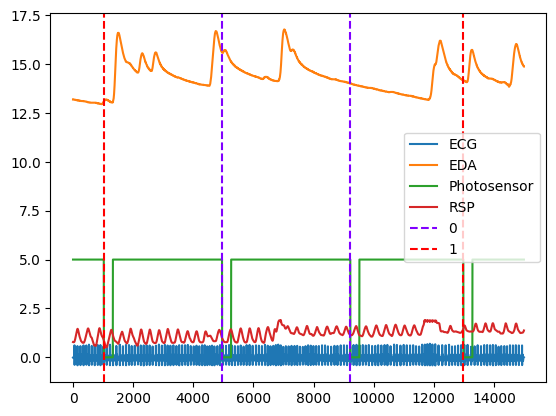

In [ ]:
# Plot the location of event with the signals
plot = nk.events_plot(events, data)

Biosignals processing can be done quite easily using NeuroKit with the bio_process() function. Simply provide the appropriate biosignal channels and additional channels that you want to keep (for example, the photosensor), and bio_process() will take care of the rest. It will return a dataframe containing processed signals and a dictionary containing useful information.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

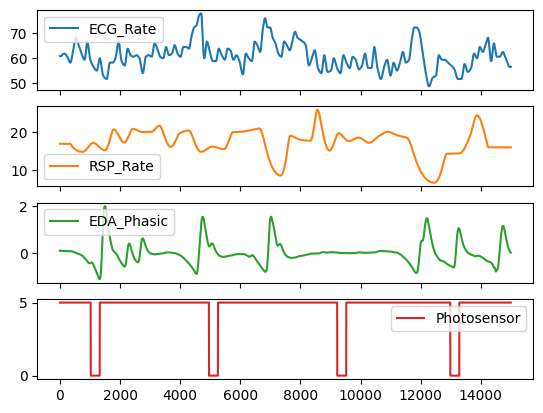

In [ ]:
# Process the signal
data_clean, info = nk.bio_process(ecg=data["ECG"], 
                                  rsp=data["RSP"], 
                                  eda=data["EDA"], 
                                  keep=data["Photosensor"], 
                                  sampling_rate=100)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", "EDA_Phasic", "Photosensor"]].plot(subplots=True)

We now have to transform this dataframe into epochs, i.e. segments (chunks) of data around the events using epochs_create(). We want it to start 1 second before the event onset and end 6 seconds after. These values are passed into the epochs_start and epochs_end arguments, respectively.

Our epochs will then cover the region from -1 s to +6 s (i.e., 700 data points since the signal is sampled at 100Hz).

Let’s plot some of the signals of the first epoch (and transform them to the same scale for visualization purposes).

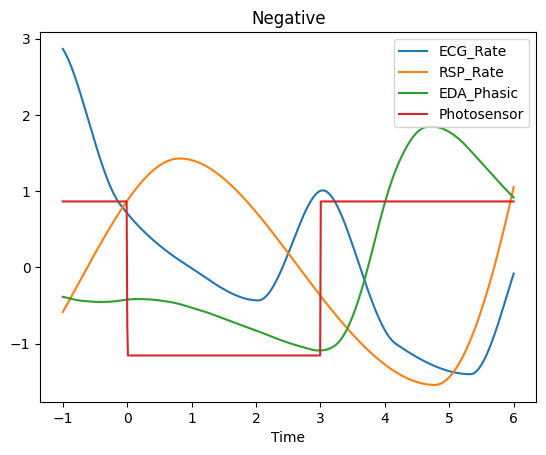

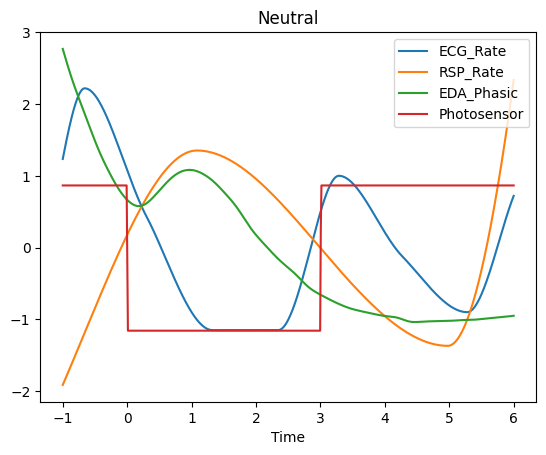

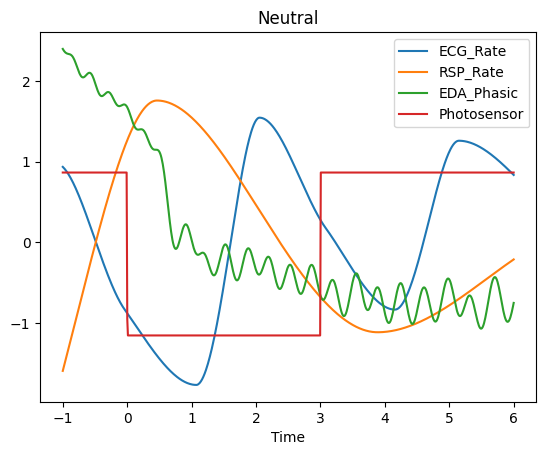

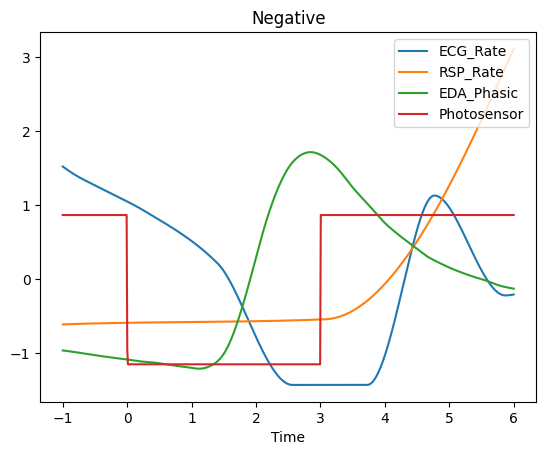

In [ ]:
# Build and plot epochs
epochs = nk.epochs_create(data_clean, events, sampling_rate=100, epochs_start=-1, epochs_end=6)

# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals
    nk.signal_plot(epoch[['ECG_Rate', 'RSP_Rate','EDA_Phasic', "Photosensor"]], 
                   title=epoch['Condition'].values[0],  # Extract condition name
                   standardize=True)

With these segments, we are able to compare how the physiological signals vary across the different events. We do this by:

Iterating through our object epochs

Storing the mean value of $X$ feature of each condition in a new dictionary

Saving the results in a readable format

We will call these 3 objects epochs-dictionary, the mean-dictionary and our results-dataframe.

In [ ]:
df = {}  # Initialize an empty dict to store the results
         
# Iterate through epochs index and data
for epoch_index, epoch in epochs.items():
    df[epoch_index] = {}  # Initialize an empty dict inside of it
                            

    # Note: We will use the 100th value (corresponding to the event onset, 0s) as the baseline

    # ECG ====
    ecg_baseline = epoch["ECG_Rate"].values[100]  # Baseline
    ecg_mean = epoch["ECG_Rate"][0:4].mean()  # Mean heart rate in the 0-4 seconds
    # Store ECG in df
    df[epoch_index]["ECG_Rate_Mean"] = ecg_mean - ecg_baseline  # Correct for baseline

    # RSP ====
    rsp_baseline = epoch["RSP_Rate"].values[100]  # Baseline
    rsp_rate = epoch["RSP_Rate"][0:6].mean()  # Longer window for RSP that has a slower dynamic
    # Store RSP in df
    df[epoch_index]["RSP_Rate_Mean"] = rsp_rate - rsp_baseline  # Correct for baseline

    
    # EDA/SCR ====
    scr_max = epoch["SCR_Amplitude"][0:6].max()  # Maximum SCR peak
    # If no SCR, consider the magnitude, i.e. that the value is 0
    if np.isnan(scr_max):
        scr_max = 0  
    # Store SCR in df
    df[epoch_index]["SCR_Magnitude"] = scr_max

df = pd.DataFrame.from_dict(df, orient="index")  # Convert to a dataframe
df["Condition"] = condition_list  # Add the conditions
df  # Print DataFrame

C:\Users\lauri\AppData\Local\Temp\ipykernel_35816\4246861920.py:12: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  ecg_mean = epoch["ECG_Rate"][0:4].mean()  # Mean heart rate in the 0-4 seconds
C:\Users\lauri\AppData\Local\Temp\ipykernel_35816\4246861920.py:18: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  rsp_rate = epoch["RSP_Rate"][0:6].mean()  # Longer window for RSP that has a slower dynamic
C:\Users\lauri\AppData\Local\Temp\ipykernel_35816\4246861920.py:24: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j]

,ECG_Rate_Mean,RSP_Rate_Mean,SCR_Magnitude,Condition
1,-2.005527,-0.591449,3.114808,Negative
2,-3.119900,-0.009901,0.000000,Neutral
3,1.336250,-0.899208,0.000000,Neutral
4,-3.543494,0.646818,1.675922,Negative


In [ ]:
df = nk.bio_analyze(epochs, sampling_rate=100)
df

,Label,Condition,Event_Onset,ECG_Rate_Baseline,ECG_Rate_Max,ECG_Rate_Min,ECG_Rate_Mean,ECG_Rate_SD,ECG_Rate_Max_Time,ECG_Rate_Min_Time,...,RSP_RVT_Baseline,RSP_RVT_Mean,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime,RSA_P2T,RSA_Gates
1,1,Negative,1024,58.962843,1.037157,-7.238706,-3.416404,2.462046,3.035765,5.329041,...,0.225643,-0.037677,1.995617,1,3.114808,4.718169,1.74,NaN,-56.170030,-3.552714e-15
2,2,Neutral,4957,64.000846,-0.056683,-5.177317,-3.209327,1.661333,0.011445,1.323319,...,0.169809,0.019351,0.868942,0,NaN,NaN,NaN,NaN,-43.273326,-7.601609e-02
3,3,Neutral,9224,55.976284,5.248206,-1.922230,1.891089,2.279224,2.054363,1.072961,...,0.127095,0.017846,0.026651,0,NaN,NaN,NaN,NaN,-13.138628,1.358487e-01
4,4,Negative,12984,57.505912,0.186396,-5.781774,-2.941543,2.142268,4.768240,2.565093,...,0.080601,0.012434,1.056855,1,1.675922,2.845494,1.73,477.0,-24.326239,1.843122e-01
